In [4]:
import numpy as np
import scipy as sp
from scipy import spatial
import matplotlib.pyplot as plt
# this will be for ploting and seeing what happening
import plotly.graph_objects as go
#this is to get the data from my API
import requests
#manipulating data will be easier if they can pass through a pandas df
import pandas as pd

In [5]:
from k_nearest_neighbors import KNearestNeighbors

In [6]:
#set up to pull data from the API
api_url = 'http://quake-ds-production.herokuapp.com'
USGS_month = api_url + '/last/usgs/month'
EMSC_month = api_url + '/last/emsc/month'

In [35]:
emsc_df = pd.DataFrame(requests.get(EMSC_month).json()['message'])
usgs_df = pd.DataFrame(requests.get(USGS_month).json()['message'])

In [37]:
neighbors = KNearestNeighbors(5)
neighbors.fit(emsc_df.values)
#neighbors.predict([usgs_df.iloc[0]])
emsc_df.head()

,id,lat,lon,mag,place,time
0,103532,34.13,25.65,6.6,"CRETE, GREECE",1588423865600
1,103853,-15.46,-70.51,5.7,SOUTHERN PERU,1588466667700
2,103940,35.62,140.72,5.6,"NEAR EAST COAST OF HONSHU, JAPAN",1588597669100
3,104313,-6.85,129.83,6.8,BANDA SEA,1588773235300
4,104532,-4.47,154.71,6.1,"BOUGAINVILLE REGION, P.N.G.",1588850480900


In [45]:
target = emsc_df.iloc[0]
neighbors = emsc_df.iloc[1:6]
target

id              103532
lat              34.13
lon              25.65
mag                6.6
place    CRETE, GREECE
time     1588423865600
Name: 0, dtype: object

I want to fit on lat, lon, and mag and use time as a threshold value that hopefully won't really get touched

In [42]:
usgs_df.iloc[0]

id                                  32820
lat                                17.938
lon                               -66.734
mag                                   5.5
place    6km SSW of Tallaboa, Puerto Rico
time                        1588417997000
Name: 0, dtype: object

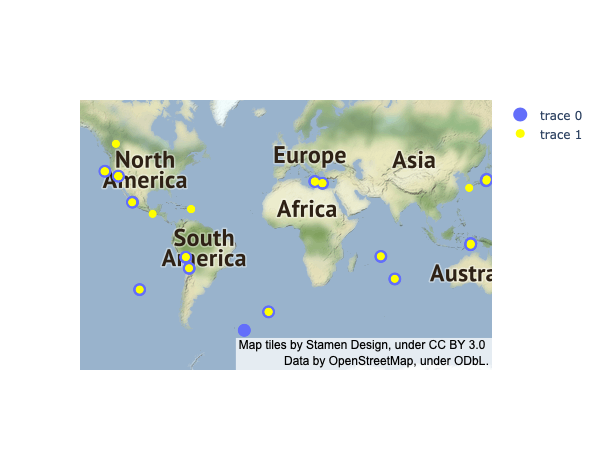

In [79]:
fig = go.Figure(go.Scattermapbox(
    lat=emsc_df['lat'],
    lon=emsc_df['lon'], 
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=14
    ),
    text=emsc_df[['mag', 'id']]))

fig.update_layout(
    hovermode='closest', 
    mapbox=dict(
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=0,
            lon=0
        ),
        pitch=0,
        zoom=0
    ))
fig.add_trace(go.Scattermapbox(
    lat=usgs_df['lat'],
    lon=usgs_df['lon'], 
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=9,
        color='yellow'
    ),
    text=usgs_df[['mag', 'id']])
)
fig.update_layout(mapbox_style="stamen-terrain")
fig.show()

### Observations

so in that map there are very clearly earthquakes that overlap with one another, I just need to find a way to identify them. I think I'm going to write a function that takes in two points and then displays them on a map

In [111]:
# This is a helper function so that once I have neigbors I can just
# plot them to see what is going on. 
def plot_quakes(target, neighbors):
    fig = go.Figure(go.Scattermapbox(
        lat=target['lat'],
        lon=target['lon'], 
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=14
        ),
        text=target[['mag', 'time', 'place']]))

    fig.update_layout(
        hovermode='closest', 
        mapbox=dict(
            bearing=0,
            center=go.layout.mapbox.Center(
                lat=0,
                lon=0
            ),
            pitch=0,
            zoom=0
        ))
    fig.add_trace(go.Scattermapbox(
        lat=neighbors['lat'],
        lon=neighbors['lon'], 
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=9,
            color='yellow'
        ),
        text=neighbors[['mag', 'time','place']])
    )
    fig.update_layout(mapbox_style="stamen-terrain")
    fig.show()

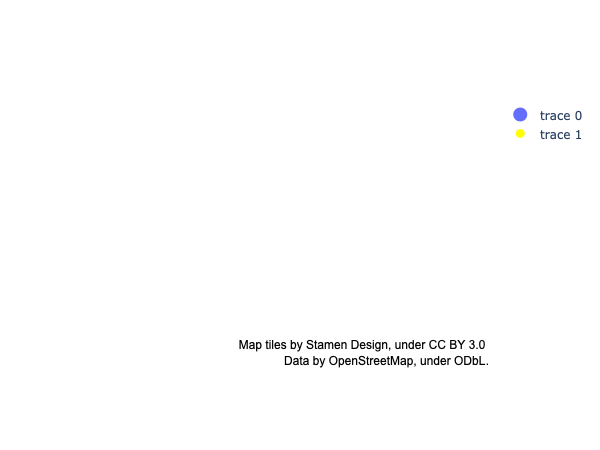

In [51]:
plot_quakes(target, neighbors)

In [108]:
# Now I need to build my K-nearest-neighbors, I'm going to start with the
# base model that I built on monday 
class QuakeNearestNeighbors():
    def __init__(self, neighbors):
        self.neighbors = neighbors

    def fit(self, data):
        self.data = data
        self.matching = data[['lat', 'lon', 'mag']].values

    def predict(self, y):
        match = y[['lat','lon','mag']].values
        dist = spatial.distance_matrix(self.matching, [match])
        kmin_index = np.argsort(dist, axis=0)
        return kmin_index[:self.neighbors], dist[kmin_index[:self.neighbors]]

31


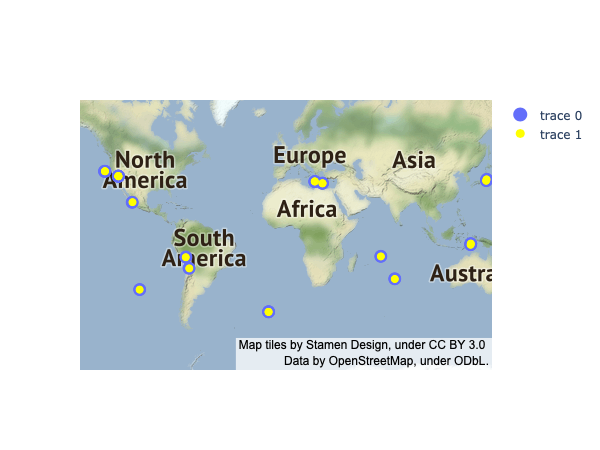

In [118]:
near = QuakeNearestNeighbors(1)
near.fit(emsc_df)
preds = []
for i, row in usgs_df.iterrows():
    target = row
    neighbor_index, dist = near.predict(target)
    pred = emsc_df.iloc[neighbor_index.squeeze()]
    if dist < 1:
        targets.append(target)
        preds.append(pred)
print(len(preds))
targets = pd.DataFrame(targets)
preds = pd.DataFrame(preds)
plot_quakes(targets, preds)

well that seems to work. Now I just need to apply this across a whole bunch of data

In [98]:
plot_quakes(target, preds)


ValueError: 
    Invalid value of type 'numpy.float64' received for the 'lat' property of scattermapbox
        Received value: 34.13

    The 'lat' property is an array that may be specified as a tuple,
    list, numpy array, or pandas Series

In [120]:
targets

,id,lat,lon,mag,place,time
2,32863,34.2045,25.7124,6.6,"89km S of Ierapetra, Greece",1588423866662
3,33028,-15.3244,-70.4168,5.7,"6km WNW of Lampa, Peru",1588466666050
5,33494,35.6765,140.8939,5.6,"8km SE of Hasaki, Japan",1588597668200
7,33973,-15.1704,-172.9345,5.5,"122km NE of Hihifo, Tonga",1588720840032
8,34232,-6.7949,129.8613,6.8,"205km NW of Saumlaki, Indonesia",1588773236960
9,34562,-4.4543,154.7127,6.1,"186km E of Taron, Papua New Guinea",1588850479839
10,35018,-29.4323,76.4736,5.5,Mid-Indian Ridge,1588970731713
11,35644,-22.7535,-68.1578,5.5,"19km NNE of San Pedro de Atacama, Chile",1589133862484
12,35775,36.4028,141.1421,5.8,"49km ESE of Hitachi, Japan",1589155113745
13,35794,-6.0661,129.9186,5.6,"259km NW of Saumlaki, Indonesia",1589159178684


In [100]:
target

,id,lat,lon,mag,place,time
2,32863,34.2045,25.7124,6.6,"89km S of Ierapetra, Greece",1588423866662


In [101]:
dist

array([[[0.0971803]]])